In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/media/xwan/HDD2/Projects/postNAS


In [7]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import networkx as nx
import numpy as np
from tqdm import tqdm
import os

In [5]:
import networkx as nx

In [5]:
from search_spaces.nas301 import NASBench301, genotype2str

In [6]:
n_samples = 40

In [7]:
ss = NASBench301(file_path='/media/xwan/HDD2/NASDatasets/nasbench301_models_v0.9/nb_models',)

In [8]:
ss.negative= False
ss.log_scale = False

In [69]:
good_archs = pickle.load(open('data/nb301_top_arch_info_with_importance.pickle', 'rb'))

In [70]:
selected_idx = np.random.RandomState(0).choice(len(good_archs), n_samples, replace=False)

In [71]:
selected_archs = [
    good_archs[i] for i in selected_idx
]

In [73]:
def prune_genotypes(genotype, weight, min_op_node_frac=0.3, ascending_weight=True, exclude_ori=True):
    from copy import deepcopy
    min_op_nodes = np.round((1 - min_op_node_frac) * 16).astype(np.int)
    weight_ord = np.argsort(weight)
    if not ascending_weight:
        weight_ord = weight_ord[::-1]
    geno = deepcopy(genotype)
    all_genos = [geno]
    for edge_order in weight_ord[:min_op_nodes]:
        geno = deepcopy(all_genos[-1])
#         print(edge_order)
        if edge_order >= 8:
            link = geno.reduce[edge_order-8][1]
            geno.reduce[edge_order - 8] = ('none', link)
        else:
            link = geno.normal[edge_order][1]
            geno.normal[edge_order] = ('none', link)
#         print(geno)
        all_genos.append(geno)
    if exclude_ori:
        all_genos = all_genos[1:]
    return all_genos

In [74]:
def extract_weight(normal_graph, reduce_graph):
    weights_norm = np.zeros(normal_graph.number_of_edges())
    weights_red = np.zeros(reduce_graph.number_of_edges())
    for ei, eo, prop in normal_graph.edges(data=True):
        order = prop['edge_order']
        w = prop['weight']
        weights_norm[order] = w
    for ei, eo, prop in reduce_graph.edges(data=True):
        order = prop['edge_order']
        w = prop['weight']
        weights_red[order] = w
    weight = np.concatenate((weights_norm, weights_red))
    return weight

In [77]:
from copy import deepcopy

In [82]:
for i, arch in enumerate(selected_archs):
    all_genos  = [deepcopy(arch['genotype'])]
    weights = extract_weight(arch['edge_graph_normal'], arch['edge_graph_reduce'])
    pruned_from_least_important = prune_genotypes(arch['genotype'], weights, min_op_node_frac=0.51)
    pruned_from_most_important = prune_genotypes(arch['genotype'], weights, min_op_node_frac=0.51, ascending_weight=False)
    all_genos += pruned_from_least_important
    all_genos += pruned_from_most_important
    pickle.dump(all_genos, open(f'./output/train_perturb_genotypes/perturb_genos_index-{i}.pickle', 'wb'))


In [6]:
import os

In [23]:
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon

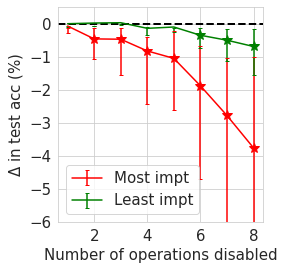

In [75]:
plt.figure(figsize=[4, 4])
most_imps = []
less_imps = []
for p in paths:
    idx = int(p.split('-')[1].split('.')[0])
    genotypes = pickle.load(open(f'output/train_perturb_genotypes/perturb_genos_index-{idx}.pickle', 'rb'))
    strs = [genotype2str(g, flatten=True) for g in genotypes]

    all_genos = []
    best_val_accs = []
    all_val_accs = []
    for j in range(len(strs)):
        try:
            geno_str_path_ = strs[j]
            geno_str_path = os.path.join(p, geno_str_path_)
            stats = pickle.load(open(os.path.join(geno_str_path, 'stats.pickle'), 'rb'))
            geno = stats['genotype']
            best_val_acc = np.max(stats['retrain_stats']['full_test_accs'])
            all_val_acc = np.array(stats['retrain_stats']['full_test_accs'])
            best_val_accs.append(best_val_acc)
            all_val_accs.append(all_val_acc)
            all_genos.append(geno)
        except:
            best_val_accs.append(np.nan)

    if len(best_val_accs):
        best_val_accs = np.array(best_val_accs).flatten()
        ori_acc = best_val_accs[0]
        less_impt = best_val_accs[1:9] - ori_acc
        most_imp = best_val_accs[9:] - ori_acc

#         plt.plot(np.arange(most_imp.shape[0])+1, most_imp, "-", color='r', alpha=0.15)
#         plt.plot(np.arange(less_impt.shape[0])+1,less_impt, "-", color='g', alpha=0.15)
        most_imps.append(most_imp)
        less_imps.append(less_impt)

most_imps = np.array(most_imps)
less_imps = np.array(less_imps)
most_impt_mean, most_impt_std = np.nanmedian(most_imps, axis=0), np.nanstd(most_imps, axis=0)/np.sqrt(most_impt_mean.shape[0])
lb_most_impt, ub_most_impt = np.nanpercentile(most_imps, 30, axis=0), np.nanpercentile(most_imps, 70, axis=0)
less_impt_mean, less_impt_std = np.nanmedian(less_imps, axis=0), np.nanstd(less_imps, axis=0)/np.sqrt(most_impt_mean.shape[0])
lb_less_impt, ub_less_impt = np.nanpercentile(less_imps, 30, axis=0), np.nanpercentile(less_imps, 70, axis=0)

plt.errorbar(np.arange(most_impt_mean.shape[0])+1, most_impt_mean, yerr=[ub_most_impt,lb_most_impt], capsize=2, color='r', label='Most impt')

plt.errorbar(np.arange(less_impt_mean.shape[0])+1,less_impt_mean, yerr=[ub_less_impt,lb_less_impt], capsize=2, color='g', label='Least impt')
for i in range(less_imps.shape[1]):
    statt = less_imps[:, i]
    statt = statt[statt == statt]
    pval = wilcoxon(statt,  alternative='less', )[1]
    if pval < 0.01:
        plt.plot(i+1, np.nanmedian(less_imps[:, i]), marker='*', color='g', markersize=10)
for i in range(most_imps.shape[1]):
    statt = most_imps[:, i]
    statt = statt[statt == statt]
    pval = wilcoxon(statt, alternative='less')[1]
#     print(statt)
    if pval < 0.01:
        plt.plot(i+1, np.nanmedian(most_imps[:, i]), marker='*', color='r', markersize=10)


# plt.fill_between(np.arange(most_impt_mean.shape[0])+1, most_impt_mean-most_impt_std,most_impt_mean+most_impt_std, color='r', alpha=0.2, label='Most impt')
# plt.fill_between(np.arange(less_impt_mean.shape[0])+1, less_impt_mean-less_impt_std,less_impt_mean+less_impt_std, color='g', alpha=0.2, label='Least impt')
plt.xlabel('Number of operations disabled')
plt.ylabel('$\Delta$ in test acc (%)')
plt.ylim([-6, 0.5])
plt.axhline(0, linewidth=2, color='k', linestyle='--')
plt.legend()
plt.savefig('./figs/remove_ops.pdf', dpi=200, bbox_inches='tight')